<a href="https://colab.research.google.com/github/youngyoung0511/Sound-AI/blob/main/250307_onset_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install PyWavelets librosa matplotlib numpy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pywt

import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


'/content/drive/My Drive/soundAI/BoysLikeGirls.mp3'

BoysLikeGirls.mp3

MagicCarpetRide_drum.mp3

Every Day.mp3

music.mp3 //꿈나라별나라

Love From The Other Side.mp3

'/content/drive/My Drive/soundAI/music_separated_0218/BoysLikeGirls_하이브리드.wav'

BoysLikeGirls_하이브리드.wav


Every Day_하이브리드.wav

꿈나라별나라_하이브리드.wav

Love From The Other Side_하이브리드.wav

## onset 추출 및 보정 + 시각화

노래 경로 입력

In [ ]:
audio_path = '/content/drive/My Drive/soundAI/music_separated_0218/Every Day_하이브리드.wav'  # 여기에 mp3 파일 경로를 입력하세요
y, sr = librosa.load(audio_path, sr=None)


오리지널 온셋 추출

In [ ]:
# 온셋 디텍션
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# 타격 시점 출력
print("Detected Onset Times:", onset_times)


Detected Onset Times: [ 49.14503401  50.00417234  50.44535147  50.88653061  51.66439909
  51.79210884  52.24489796  52.65124717  53.54521542  53.98639456
  54.4275737   55.32154195  55.73950113  56.25034014  56.4244898
  56.63346939  56.85405896  57.07464853  57.51582766  57.94539683
  58.38657596  58.83936508  59.28054422  59.72172336  60.18612245
  60.61569161  61.03365079  61.47482993  61.93922902  62.35718821
  62.80997732  63.23954649  64.13351474  64.58630385  65.01587302
  65.89823129  66.21170068  66.35102041  66.78058957  67.65133787
  68.10412698  68.54530612  69.43927438  69.88045351  70.32163265
  70.51900227  70.75120181  70.96018141  71.19238095  71.63356009
  72.08634921  72.53913832  72.96870748  73.40988662  73.83945578
  74.2922449   74.72181406  75.13977324  75.60417234  76.49814059
  76.93931973  77.36888889  77.821678    78.23963719  78.70403628
  79.13360544  79.5631746   80.01596372  80.4339229   80.88671202
  81.37433107  81.80390023  82.22185941  82.66303855  8

오리지널 온셋 시각화

박자와 BPM 정보 필요

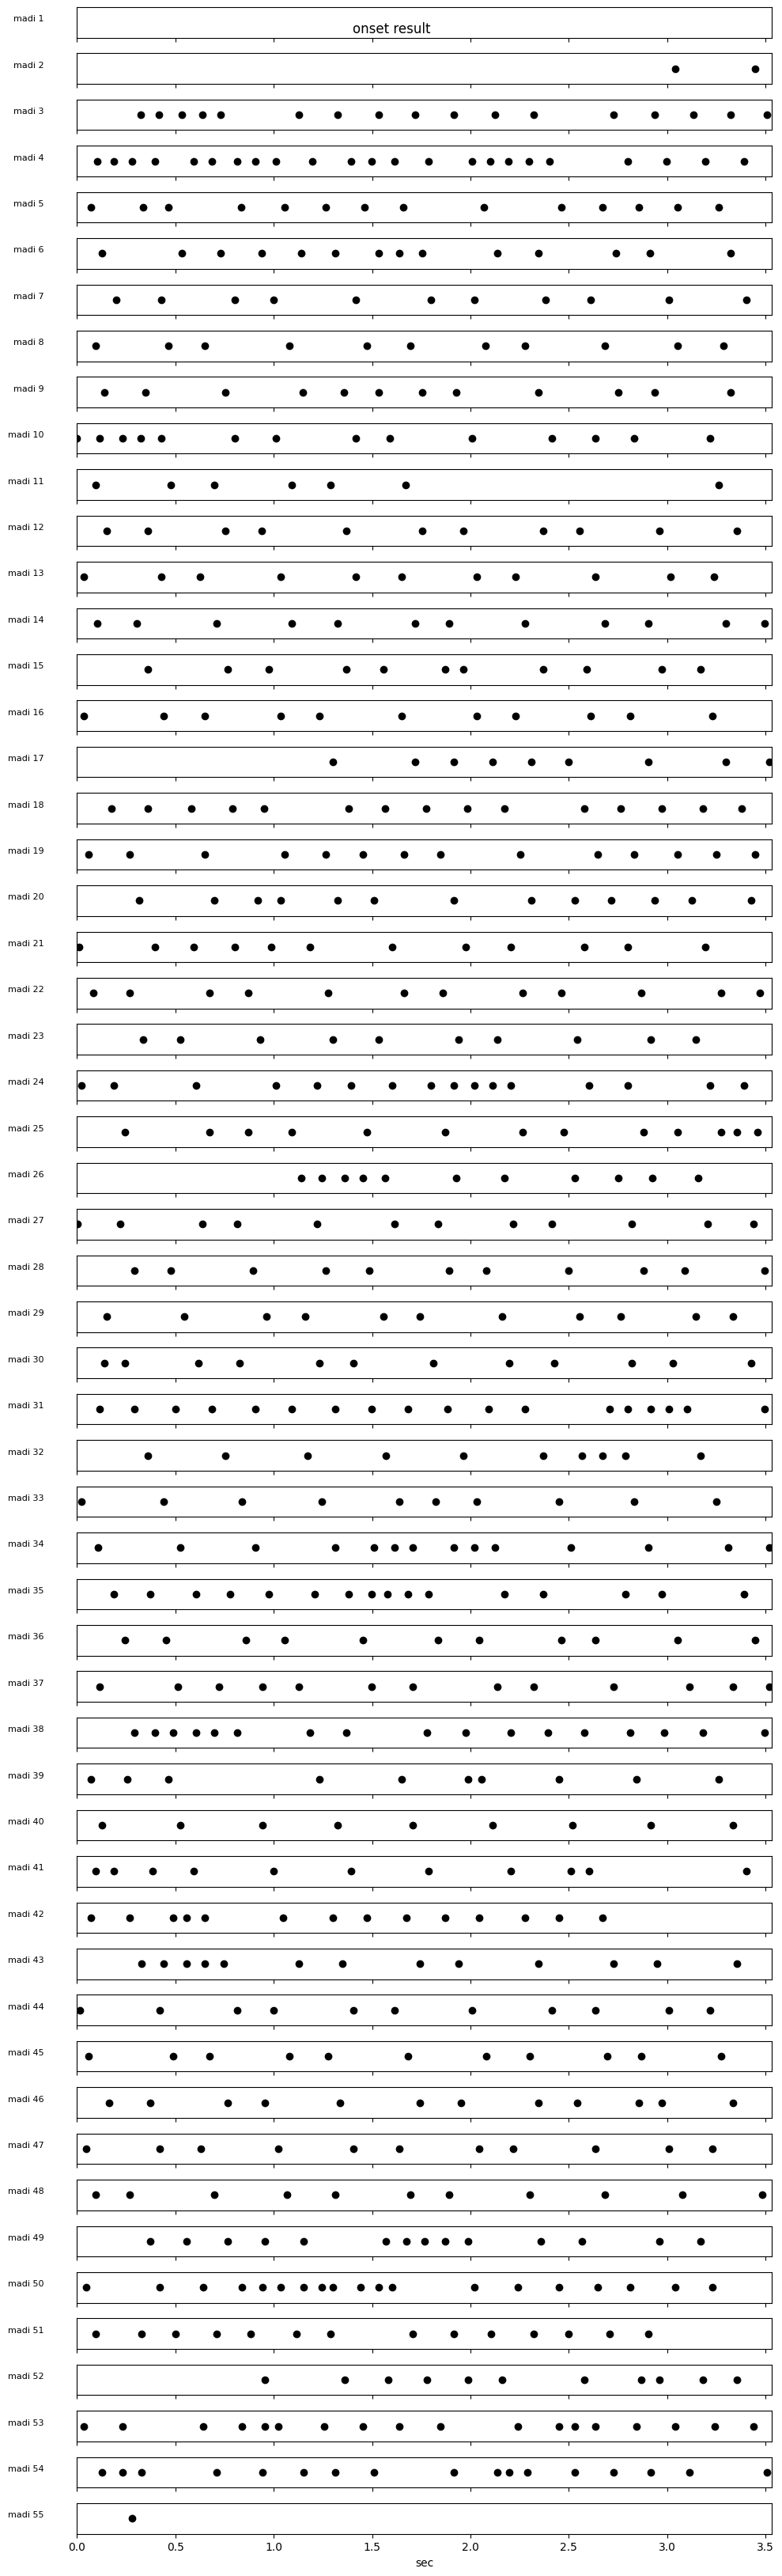

In [ ]:
# 설정된 템포(BPM) 및 마디 길이 계산
BPM = 68  # 악보에 표시된 템포
beats_per_measure = 4  # 4/4 마디 기준
seconds_per_measure = (60 / BPM) * beats_per_measure  # 1 마디의 초 단위 길이
total_time = onset_times.max()  # 전체 곡 길이
num_measures = int(np.ceil(total_time / seconds_per_measure))  # 전체 마디 수

# 마디 구간 설정
measure_times = np.arange(0, num_measures * seconds_per_measure, seconds_per_measure)

# 시각화
fig, axes = plt.subplots(num_measures, 1, figsize=(10, num_measures * 0.6), sharex=True)

for i in range(num_measures):
    ax = axes[i] if num_measures > 1 else axes  # 마디별 서브플롯 선택
    start_time = measure_times[i]
    end_time = start_time + seconds_per_measure
    mask = (onset_times >= start_time) & (onset_times < end_time)  # 해당 마디에 속하는 온셋 선택
    ax.scatter(onset_times[mask] - start_time, np.zeros_like(onset_times[mask]), color="black", marker="o")  # 온셋 표시
    ax.set_xlim(0, seconds_per_measure)
    ax.set_yticks([])
    ax.set_ylabel(f"madi {i+1}", rotation=0, labelpad=30, fontsize=8, ha='right')

plt.xlabel("sec")
plt.suptitle("onset result", fontsize=12)
plt.tight_layout()
plt.show()


온셋 균등 보정

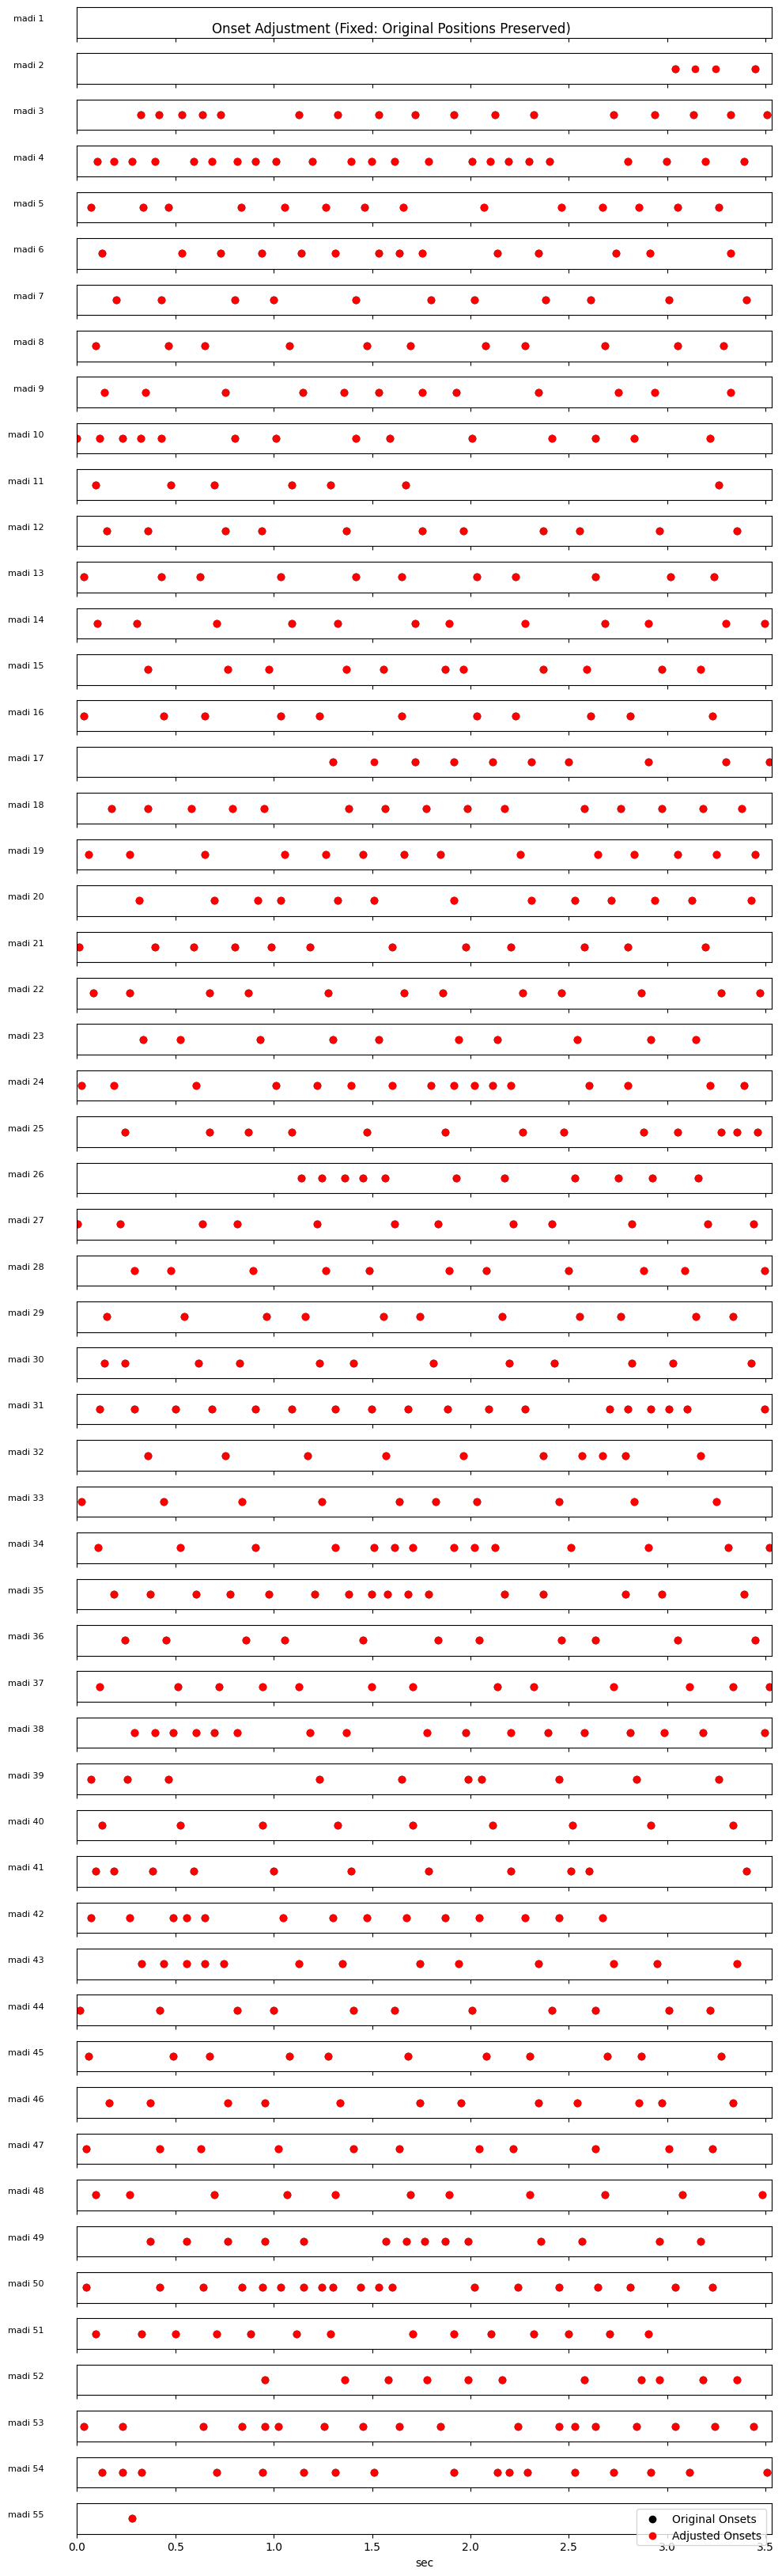

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def adjust_onsets_to_pattern_fixed(onset_times, bpm=68, beats_per_measure=4, target_counts=[4, 8, 12]):
    """
    기존 온셋의 위치를 유지하면서, 부족한 경우 기존 온셋 사이의 중간 지점을 추가하여 채움.
    """
    seconds_per_measure = (60 / bpm) * beats_per_measure
    total_time = onset_times.max()
    num_measures = int(np.ceil(total_time / seconds_per_measure))
    measure_times = np.arange(0, num_measures * seconds_per_measure, seconds_per_measure)

    # 기존 온셋을 유지하기 위해 복사
    original_onsets = np.copy(onset_times)  # 기존 온셋 유지
    new_onsets = []  # 새로 추가할 온셋 저장 리스트

    for i in range(num_measures):
        start_time = measure_times[i]
        end_time = start_time + seconds_per_measure
        mask = (onset_times >= start_time) & (onset_times < end_time)
        measure_onsets = np.sort(onset_times[mask])

        # ** 빈 배열 방지: 온셋이 없는 경우 건너뛰기 **
        if len(measure_onsets) == 0:
            continue

        # 목표 개수 결정 (5,6,7개일 경우 8개, 9,10,11개일 경우 12개)
        current_count = len(measure_onsets)
        if current_count in [5, 6, 7]:
            target_count = 8
        elif current_count in [9, 10, 11]:
            target_count = 12
        else:
            target_count = min(target_counts, key=lambda x: abs(x - current_count))

        # 기존 온셋을 유지한 채, 필요한 온셋만 추가
        if current_count < target_count:
            new_points_needed = target_count - current_count
            temp_onsets = list(measure_onsets)  # 기존 온셋을 수정하지 않기 위해 리스트 복사

            while len(new_onsets) < new_points_needed:
                if len(temp_onsets) < 2:  # **온셋이 하나뿐이면 추가할 수 없음**
                    break

                # **가장 큰 간격을 찾아서 중간 지점에 새로운 온셋 추가 (기존 온셋 유지)**
                max_gap_idx = np.argmax(np.diff(temp_onsets))  # 가장 큰 간격 찾기
                new_onset = (temp_onsets[max_gap_idx] + temp_onsets[max_gap_idx + 1]) / 2  # 중간 지점 추가
                new_onsets.append(new_onset)  # 새로운 온셋을 별도 저장
                temp_onsets.insert(max_gap_idx + 1, new_onset)  # 기존 온셋 수정 없이 삽입

    # 기존 온셋과 새로운 온셋을 합쳐 최종 결과 반환
    final_onsets = np.sort(np.concatenate((original_onsets, np.array(new_onsets))))

    return final_onsets, measure_times, seconds_per_measure

# 오디오 파일 로드
audio_path = '/content/drive/My Drive/soundAI/music_separated_0218/BoysLikeGirls_하이브리드.wav'
y, sr = librosa.load(audio_path, sr=None)

# 온셋 디텍션
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# 후보정 적용 (기존 온셋을 유지하면서 보정)
adjusted_onset_times, measure_times, seconds_per_measure = adjust_onsets_to_pattern_fixed(onset_times)

# 결과 시각화
fig, axes = plt.subplots(len(measure_times), 1, figsize=(10, len(measure_times) * 0.6), sharex=True)

for i in range(len(measure_times)):
    ax = axes[i] if len(measure_times) > 1 else axes
    start_time = measure_times[i]
    end_time = start_time + seconds_per_measure
    mask_original = (onset_times >= start_time) & (onset_times < end_time)
    mask_adjusted = (adjusted_onset_times >= start_time) & (adjusted_onset_times < end_time)

    # 원래 온셋 (검은색)
    ax.scatter(onset_times[mask_original] - start_time, np.zeros_like(onset_times[mask_original]), color="black", marker="o", label="Original Onsets")

    # 보정된 온셋 (빨간색)
    ax.scatter(adjusted_onset_times[mask_adjusted] - start_time, np.zeros_like(adjusted_onset_times[mask_adjusted]), color="red", marker="o", label="Adjusted Onsets")

    ax.set_xlim(0, seconds_per_measure)
    ax.set_yticks([])
    ax.set_ylabel(f"madi {i+1}", rotation=0, labelpad=30, fontsize=8, ha='right')

plt.xlabel("sec")
plt.suptitle("Onset Adjustment (Fixed: Original Positions Preserved)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


## onset 추출 및 보정 + 시각화

노래 경로 입력

In [ ]:
audio_path = '/content/drive/My Drive/soundAI/music_separated_0218/Love From The Other Side_하이브리드.wav'  # 여기에 mp3 파일 경로를 입력하세요
y, sr = librosa.load(audio_path, sr=None)


오리지널 온셋 추출

In [ ]:
# 온셋 디텍션
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# 타격 시점 출력
print("Detected Onset Times:", onset_times)


Detected Onset Times: [2.32199546e-02 9.28798186e-02 2.90249433e-01 4.99229025e-01
 6.96598639e-01 1.06811791e+00 1.25387755e+00 1.55573696e+00
 1.82276644e+00 2.02013605e+00 2.31038549e+00 2.60063492e+00
 2.78639456e+00 3.15791383e+00 3.34367347e+00 3.54104308e+00
 3.73841270e+00 4.10993197e+00 4.29569161e+00 4.58594104e+00
 4.86458050e+00 5.05034014e+00 5.32897959e+00 5.61922902e+00
 5.80498866e+00 6.19972789e+00 6.38548753e+00 6.57124717e+00
 6.76861678e+00 7.15174603e+00 7.33750567e+00 7.59292517e+00
 7.91800454e+00 8.10376417e+00 8.38240363e+00 8.64943311e+00
 8.83519274e+00 9.24154195e+00 9.41569161e+00 9.61306122e+00
 9.77560091e+00 1.01935601e+01 1.03793197e+01 1.06579592e+01
 1.09598186e+01 1.11339683e+01 1.14242177e+01 1.15170975e+01
 1.16215873e+01 1.17841270e+01 1.18653968e+01 1.20859864e+01
 1.22717460e+01 1.26432653e+01 1.30263946e+01 1.32237642e+01
 1.34211338e+01 1.36068934e+01 1.37810431e+01 1.41641723e+01
 1.45473016e+01 1.47678912e+01 1.49304308e+01 1.51161905e+01
 1

오리지널 온셋 시각화

박자와 BPM 정보 필요

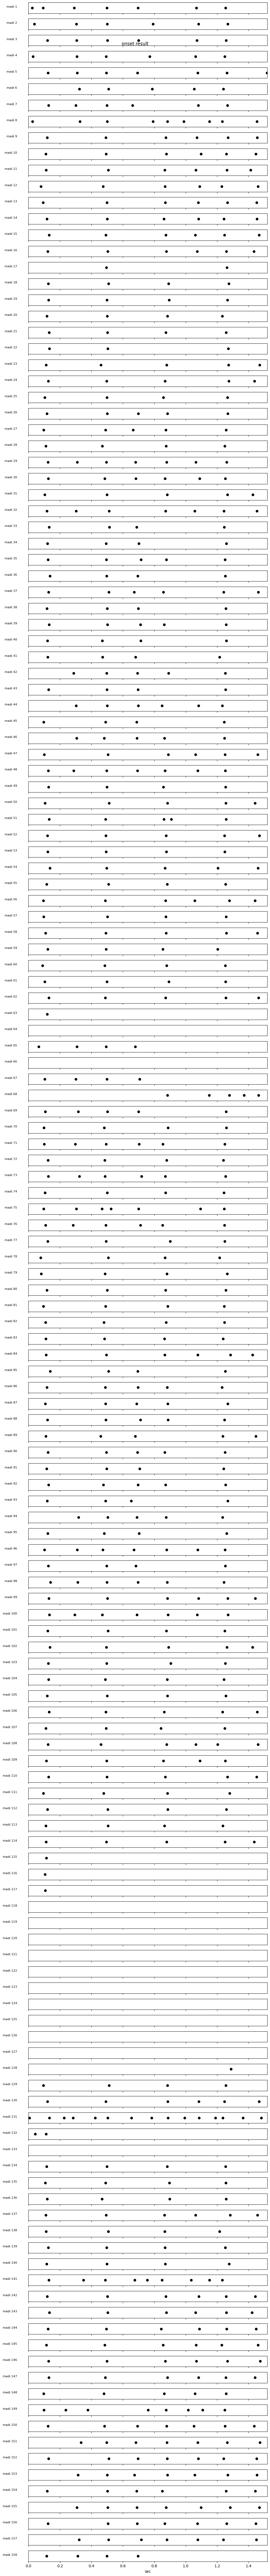

In [ ]:
# 설정된 템포(BPM) 및 마디 길이 계산
BPM = 158  # 악보에 표시된 템포
beats_per_measure = 4  # 4/4 마디 기준
seconds_per_measure = (60 / BPM) * beats_per_measure  # 1 마디의 초 단위 길이
total_time = onset_times.max()  # 전체 곡 길이
num_measures = int(np.ceil(total_time / seconds_per_measure))  # 전체 마디 수

# 마디 구간 설정
measure_times = np.arange(0, num_measures * seconds_per_measure, seconds_per_measure)

# 시각화
fig, axes = plt.subplots(num_measures, 1, figsize=(10, num_measures * 0.6), sharex=True)

for i in range(num_measures):
    ax = axes[i] if num_measures > 1 else axes  # 마디별 서브플롯 선택
    start_time = measure_times[i]
    end_time = start_time + seconds_per_measure
    mask = (onset_times >= start_time) & (onset_times < end_time)  # 해당 마디에 속하는 온셋 선택
    ax.scatter(onset_times[mask] - start_time, np.zeros_like(onset_times[mask]), color="black", marker="o")  # 온셋 표시
    ax.set_xlim(0, seconds_per_measure)
    ax.set_yticks([])
    ax.set_ylabel(f"madi {i+1}", rotation=0, labelpad=30, fontsize=8, ha='right')

plt.xlabel("sec")
plt.suptitle("onset result", fontsize=12)
plt.tight_layout()
plt.show()


온셋 균등 보정

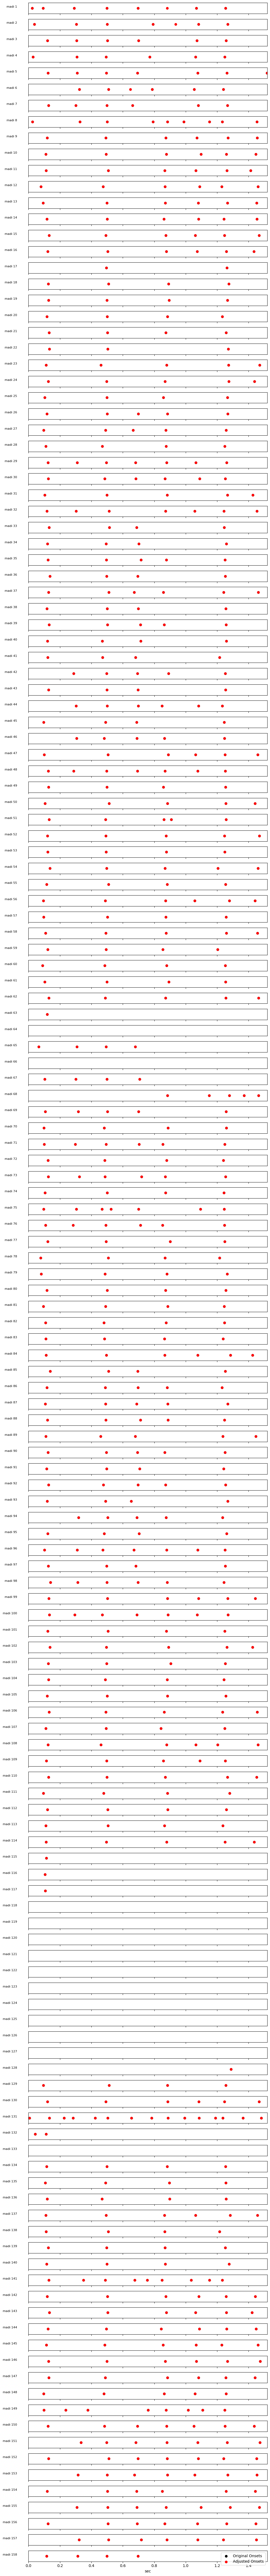

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def adjust_onsets_to_pattern_fixed(onset_times, bpm=158, beats_per_measure=4, target_counts=[4, 8, 12]):
    """
    기존 온셋의 위치를 유지하면서, 부족한 경우 기존 온셋 사이의 중간 지점을 추가하여 채움.
    """
    seconds_per_measure = (60 / bpm) * beats_per_measure
    total_time = onset_times.max()
    num_measures = int(np.ceil(total_time / seconds_per_measure))
    measure_times = np.arange(0, num_measures * seconds_per_measure, seconds_per_measure)

    # 기존 온셋을 유지하기 위해 복사
    original_onsets = np.copy(onset_times)  # 기존 온셋 유지
    new_onsets = []  # 새로 추가할 온셋 저장 리스트

    for i in range(num_measures):
        start_time = measure_times[i]
        end_time = start_time + seconds_per_measure
        mask = (onset_times >= start_time) & (onset_times < end_time)
        measure_onsets = np.sort(onset_times[mask])

        # ** 빈 배열 방지: 온셋이 없는 경우 건너뛰기 **
        if len(measure_onsets) == 0:
            continue

        # 목표 개수 결정 (5,6,7개일 경우 8개, 9,10,11개일 경우 12개)
        current_count = len(measure_onsets)
        if current_count in [5, 6, 7]:
            target_count = 8
        elif current_count in [9, 10, 11]:
            target_count = 12
        else:
            target_count = min(target_counts, key=lambda x: abs(x - current_count))

        # 기존 온셋을 유지한 채, 필요한 온셋만 추가
        if current_count < target_count:
            new_points_needed = target_count - current_count
            temp_onsets = list(measure_onsets)  # 기존 온셋을 수정하지 않기 위해 리스트 복사

            while len(new_onsets) < new_points_needed:
                if len(temp_onsets) < 2:  # **온셋이 하나뿐이면 추가할 수 없음**
                    break

                # **가장 큰 간격을 찾아서 중간 지점에 새로운 온셋 추가 (기존 온셋 유지)**
                max_gap_idx = np.argmax(np.diff(temp_onsets))  # 가장 큰 간격 찾기
                new_onset = (temp_onsets[max_gap_idx] + temp_onsets[max_gap_idx + 1]) / 2  # 중간 지점 추가
                new_onsets.append(new_onset)  # 새로운 온셋을 별도 저장
                temp_onsets.insert(max_gap_idx + 1, new_onset)  # 기존 온셋 수정 없이 삽입

    # 기존 온셋과 새로운 온셋을 합쳐 최종 결과 반환
    final_onsets = np.sort(np.concatenate((original_onsets, np.array(new_onsets))))

    return final_onsets, measure_times, seconds_per_measure

#############################
audio_path = '/content/drive/My Drive/soundAI/music_separated_0218/Love From The Other Side_하이브리드.wav'  # 여기에 mp3 파일 경로를 입력하세요
y, sr = librosa.load(audio_path, sr=None)


#############################


# 온셋 디텍션
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# 후보정 적용 (기존 온셋을 유지하면서 보정)
adjusted_onset_times, measure_times, seconds_per_measure = adjust_onsets_to_pattern_fixed(onset_times)

# 결과 시각화
fig, axes = plt.subplots(len(measure_times), 1, figsize=(10, len(measure_times) * 0.6), sharex=True)

for i in range(len(measure_times)):
    ax = axes[i] if len(measure_times) > 1 else axes
    start_time = measure_times[i]
    end_time = start_time + seconds_per_measure
    mask_original = (onset_times >= start_time) & (onset_times < end_time)
    mask_adjusted = (adjusted_onset_times >= start_time) & (adjusted_onset_times < end_time)

    # 원래 온셋 (검은색)
    ax.scatter(onset_times[mask_original] - start_time, np.zeros_like(onset_times[mask_original]), color="black", marker="o", label="Original Onsets")

    # 보정된 온셋 (빨간색)
    ax.scatter(adjusted_onset_times[mask_adjusted] - start_time, np.zeros_like(adjusted_onset_times[mask_adjusted]), color="red", marker="o", label="Adjusted Onsets")

    ax.set_xlim(0, seconds_per_measure)
    ax.set_yticks([])
    ax.set_ylabel(f"madi {i+1}", rotation=0, labelpad=30, fontsize=8, ha='right')

plt.xlabel("sec")
plt.suptitle("", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# 기존 온셋과 보정된 온셋 비교
original_onsets_set = set(np.round(onset_times, 5))  # 기존 온셋 (소수점 오차 방지)
adjusted_onsets_set = set(np.round(adjusted_onset_times, 5))  # 보정된 온셋

# ✅ 기존 온셋이 유지되었는지 확인
unchanged_onsets = original_onsets_set.intersection(adjusted_onsets_set)
if len(unchanged_onsets) == len(original_onsets_set):
    print("✅ 기존 온셋은 유지되었습니다!")
else:
    print("⚠ 기존 온셋 일부가 변경되었을 가능성이 있습니다.")

# ✅ 추가된 온셋 확인
newly_added_onsets = adjusted_onsets_set - original_onsets_set
print(f"🔴 추가된 온셋 개수: {len(newly_added_onsets)}")
print(f"🔴 추가된 온셋 위치: {sorted(newly_added_onsets)}")

# ✅ 마디별 온셋 개수 확인
seconds_per_measure = (60 / 150) * 4  # BPM = 150, 4/4 마디 기준
measure_times = np.arange(0, np.max(adjusted_onset_times), seconds_per_measure)

for i, start_time in enumerate(measure_times):
    end_time = start_time + seconds_per_measure
    mask = (adjusted_onset_times >= start_time) & (adjusted_onset_times < end_time)
    count = np.sum(mask)
    print(f"🎵 마디 {i+1}: {count}개 (보정 후)")


✅ 기존 온셋은 유지되었습니다!
🔴 추가된 온셋 개수: 3
🔴 추가된 온셋 위치: [0.88236, 2.45551, 8.24308]
🎵 마디 1: 9개 (보정 후)
🎵 마디 2: 7개 (보정 후)
🎵 마디 3: 6개 (보정 후)
🎵 마디 4: 7개 (보정 후)
🎵 마디 5: 6개 (보정 후)
🎵 마디 6: 7개 (보정 후)
🎵 마디 7: 7개 (보정 후)
🎵 마디 8: 8개 (보정 후)
🎵 마디 9: 6개 (보정 후)
🎵 마디 10: 6개 (보정 후)
🎵 마디 11: 7개 (보정 후)
🎵 마디 12: 6개 (보정 후)
🎵 마디 13: 6개 (보정 후)
🎵 마디 14: 7개 (보정 후)
🎵 마디 15: 6개 (보정 후)
🎵 마디 16: 4개 (보정 후)
🎵 마디 17: 4개 (보정 후)
🎵 마디 18: 4개 (보정 후)
🎵 마디 19: 4개 (보정 후)
🎵 마디 20: 4개 (보정 후)
🎵 마디 21: 4개 (보정 후)
🎵 마디 22: 5개 (보정 후)
🎵 마디 23: 5개 (보정 후)
🎵 마디 24: 4개 (보정 후)
🎵 마디 25: 6개 (보정 후)
🎵 마디 26: 5개 (보정 후)
🎵 마디 27: 5개 (보정 후)
🎵 마디 28: 7개 (보정 후)
🎵 마디 29: 5개 (보정 후)
🎵 마디 30: 7개 (보정 후)
🎵 마디 31: 6개 (보정 후)
🎵 마디 32: 4개 (보정 후)
🎵 마디 33: 5개 (보정 후)
🎵 마디 34: 4개 (보정 후)
🎵 마디 35: 6개 (보정 후)
🎵 마디 36: 5개 (보정 후)
🎵 마디 37: 5개 (보정 후)
🎵 마디 38: 4개 (보정 후)
🎵 마디 39: 4개 (보정 후)
🎵 마디 40: 6개 (보정 후)
🎵 마디 41: 3개 (보정 후)
🎵 마디 42: 7개 (보정 후)
🎵 마디 43: 4개 (보정 후)
🎵 마디 44: 6개 (보정 후)
🎵 마디 45: 7개 (보정 후)
🎵 마디 46: 6개 (보정 후)
🎵 마디 47: 4개 (보정 후)
🎵 마디 48: 5개 (보정 후)
🎵 마디 49: 6개 (보정 후)
🎵 마디